# Preparing the dataset

In [68]:
import pandas as pd
import numpy as np
import ml_utils as mlu
import ml_utils_classification as uc
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [69]:
symbol = 'AAPL'
aapl = yf.Ticker(symbol)

In [70]:
data = aapl.history(start="2014-05-01", end="2025-05-12", actions=False)

In [71]:
data.index = pd.to_datetime(data.index)

<Axes: xlabel='Date'>

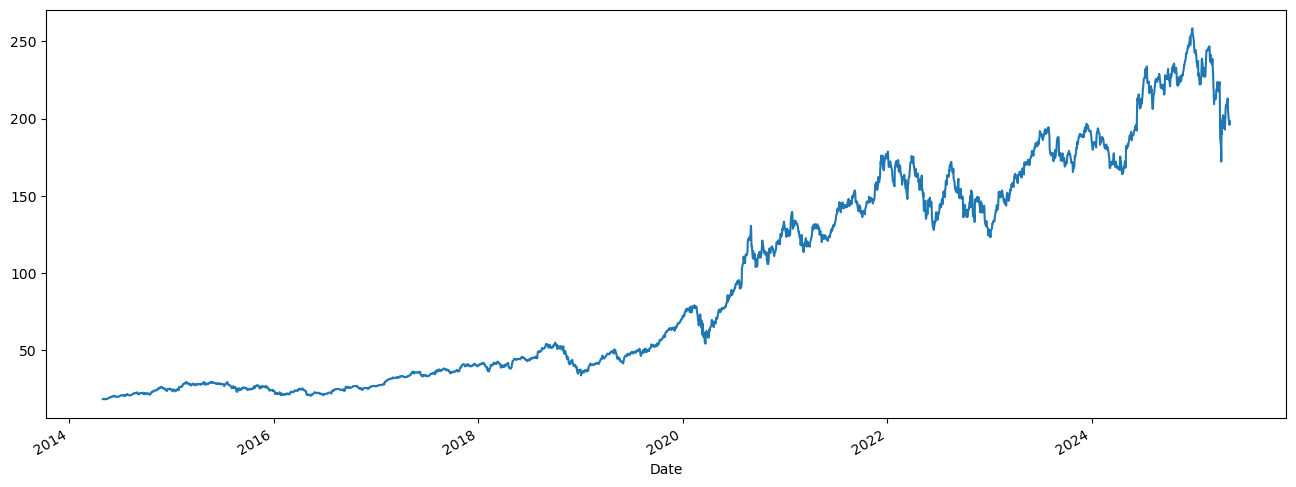

In [72]:
data['Close'].plot(figsize=(16,6))

In [73]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2014-05-01 00:00:00-04:00,18.511160,18.598713,18.334805,18.494902,244048000
2014-05-02 00:00:00-04:00,18.521788,18.579949,18.439550,18.529291,191514400
2014-05-05 00:00:00-04:00,18.452995,18.792575,18.448617,18.791323,287067200
2014-05-06 00:00:00-04:00,18.817593,18.899205,18.586517,18.586517,374564400
2014-05-07 00:00:00-04:00,18.612784,18.676572,18.377642,18.521479,282864400
...,...,...,...,...,...
2025-05-05 00:00:00-04:00,202.834025,203.832716,197.950430,198.629532,69018500
2025-05-06 00:00:00-04:00,197.950420,200.387212,196.761976,198.250015,51216500
2025-05-07 00:00:00-04:00,198.909155,199.178806,192.996910,195.992981,68536700


In [74]:
data['delta'] = data['Close'].diff()

In [75]:
data['direction'] = (data['delta'] > 0).astype(int)

In [76]:
data = mlu.calc_all_default(data)

In [77]:
def direction_momentum(df, horizons=[5, 10, 20, 60]):
    new_df = df.copy()
    for horizon in horizons:
        name = f"direction_mom_{horizon}"
        new_df[name] = new_df['direction'].rolling(horizon).sum() - (horizon/2)
    return new_df

In [78]:
data = direction_momentum(data)

In [79]:
data['next_direction'] = data['direction'].shift(-1)

In [80]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'delta', 'direction',
       'RSI_14', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100', 'EMA_20',
       'EMA_50', 'EMA_100', 'MACD', 'MACD_Signal', 'BBU_20_2.0', 'BBL_20_2.0',
       'momentum_10', 'ATR_14', 'direction_mom_5', 'direction_mom_10',
       'direction_mom_20', 'direction_mom_60', 'next_direction'],
      dtype='object')

In [81]:
data = data.dropna()

In [82]:
# Dataset for regression trees
reg_data = data[['next_direction', 'direction', 'direction_mom_5', 'direction_mom_10',
       'direction_mom_20', 'direction_mom_60']]

X = reg_data[['direction', 'direction_mom_5', 'direction_mom_10',
       'direction_mom_20', 'direction_mom_60']]

y = reg_data[['next_direction']]

X_train, X_val, y_train, y_val = uc.split_before_year(X, y, 2022)


# XGB Classification without sentiment

In [83]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [128]:
n_estimators = 20000
learning_rate = 0.005
subsample = 0.8
colsample_bytree = 0.8
gamma = 0.1
scale_pos_weight = np.sum(y.values == 0) / np.sum(y.values == 1)

In [129]:
model = XGBClassifier(n_estimators=n_estimators,
                      learning_rate=learning_rate,
                      subsample=subsample,
                      colsample_bytree=colsample_bytree,
                      gamma=gamma,
                      scale_pos_weight=scale_pos_weight,
                      use_label_encoder=False,
                      eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20000, n_jobs=None,
              num_parallel_tree=None, ...)

In [130]:
y_train_pred = model.predict(X_train)

print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

Accuracy: 0.8184296619411123
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.81       860
         1.0       0.83      0.82      0.83       974

    accuracy                           0.82      1834
   macro avg       0.82      0.82      0.82      1834
weighted avg       0.82      0.82      0.82      1834



In [131]:
y_pred = model.predict(X_val)

In [132]:
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.544047619047619
              precision    recall  f1-score   support

         0.0       0.52      0.53      0.52       397
         1.0       0.57      0.56      0.56       443

    accuracy                           0.54       840
   macro avg       0.54      0.54      0.54       840
weighted avg       0.54      0.54      0.54       840



In [141]:
# Comparison with random model
p = np.mean(y_val.values)
#print(p)
y_random_weighted = np.random.choice([0, 1], size=len(y_val), p=[1 - p, p])

print("Accuracy:", accuracy_score(y_val, y_random_weighted))
print(classification_report(y_val, y_random_weighted))

Accuracy: 0.5095238095238095
              precision    recall  f1-score   support

         0.0       0.48      0.48      0.48       397
         1.0       0.54      0.53      0.53       443

    accuracy                           0.51       840
   macro avg       0.51      0.51      0.51       840
weighted avg       0.51      0.51      0.51       840

